<a href="https://colab.research.google.com/github/ZenQe/PyTorch_Baseline_Imagewoof/blob/main/PyTorch_Imagewoof.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder

import torch.nn as nn
import torch.nn.functional as F

import matplotlib
import matplotlib.pyplot as plt

## Загрузка и предобработка данных

In [2]:
#Загрузка датасета

dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2-160.tgz"
download_url(dataset_url, '.')

#разархивируем данные
with tarfile.open('./imagewoof2-160.tgz', 'r:gz') as tar: #read file in r mode
  tar.extractall(path = './data') #extract all folders from zip file and store under folder named data

In [3]:
data_dir = './data/imagewoof2-160'

print(os.listdir(data_dir))

['noisy_imagewoof.csv', 'val', 'train']


In [4]:
print(os.listdir('./data/imagewoof2-160/train'))
print(len(os.listdir('./data/imagewoof2-160/train')))

['n02093754', 'n02089973', 'n02087394', 'n02111889', 'n02088364', 'n02105641', 'n02086240', 'n02115641', 'n02096294', 'n02099601']
10


In [5]:
#классы согласно исходным данным:
classes = ['Golden retriever', 'Rhodesian ridgeback', 'Australian terrier', 'Samoyed', 'Border terrier', 'Dingo', 'Shih-Tzu', 'Beagle', 'English foxhound', 'Old English sheepdog']
len(classes)

10

In [6]:
train_directory = './data/imagewoof2-160/train'

for root, dirs, files in os.walk(train_directory):
  if files == []:
    continue
  else:
    print(len(files))

949
580
942
921
932
928
941
940
943
949


In [7]:
test_directory = './data/imagewoof2-160/val'

for root, dirs, files in os.walk(test_directory):
  if files == []:
    continue
  else:
    print(len(files))

401
224
408
429
418
422
409
410
407
401


In [8]:
# конвертируем изображение в тензор
image_size_test = ImageFolder(train_directory, tt.ToTensor())
len(image_size_test)

9025

In [9]:
#проверка размеров изображений
im_count = 0
for image,_ in image_size_test:
  im_count += 1
  print(image.shape)
  if im_count == 10:
    break    

torch.Size([3, 166, 160])
torch.Size([3, 160, 200])
torch.Size([3, 160, 213])
torch.Size([3, 160, 213])
torch.Size([3, 160, 213])
torch.Size([3, 187, 160])
torch.Size([3, 160, 182])
torch.Size([3, 160, 213])
torch.Size([3, 213, 160])
torch.Size([3, 191, 160])


In [10]:
#поиск максимальных и минимальных размеров изображений
height = []
width = []
for image,_ in image_size_test:
  height.append(image.shape[1])
  width.append(image.shape[2])
print("minimum height: {}, maximum height: {}, minimum width: {}, maximum width: {}".format(min(height), max(height), min(width), max(width)))

minimum height: 160, maximum height: 391, minimum width: 160, maximum width: 615


In [11]:
#конвертируем изображения под минимальные
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

train_tfms = tt.Compose([tt.RandomCrop(160, padding=1, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(),
                         tt.RandomRotation(degrees=15),
                         tt.ToTensor(),
                         tt.Normalize(*stats,inplace=True)])

test_tfms = tt.Compose([tt.RandomResizedCrop(160),
                        tt.ToTensor(), tt.Normalize(*stats)])

In [12]:
train_full_ds = ImageFolder(data_dir + '/train', train_tfms)

test_ds = ImageFolder(data_dir + '/val', test_tfms)

In [13]:
#проверка полученных значений

im_count = 0
for image,_ in train_full_ds:
  im_count += 1
  print(image.shape)
  if im_count == 10:
    break   

torch.Size([3, 160, 160])
torch.Size([3, 160, 160])
torch.Size([3, 160, 160])
torch.Size([3, 160, 160])
torch.Size([3, 160, 160])
torch.Size([3, 160, 160])
torch.Size([3, 160, 160])
torch.Size([3, 160, 160])
torch.Size([3, 160, 160])
torch.Size([3, 160, 160])


In [14]:
#проверка мин макс размеров после изменения размеров

height = []
width = []
for image,_ in train_full_ds:
  height.append(image.shape[1])
  width.append(image.shape[2])
print("minimum height: {}, maximum height: {}, minimum width: {}, maximum width: {}".format(min(height), max(height), min(width), max(width)))

minimum height: 160, maximum height: 160, minimum width: 160, maximum width: 160


In [15]:
img, label = train_full_ds[9000]
print(img.shape, label)
img

torch.Size([3, 160, 160]) 9


tensor([[[-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
         [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
         [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
         ...,
         [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
         [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
         [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291]],

        [[-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
         [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
         [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
         ...,
         [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
         [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
         [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183]],

        [[-2.2214, -2.2214, -2.2214,  ..., -2.2214, -2.2214, -2.2214],
         [-2.2214, -2.2214, -2.2214,  ..., -2

In [16]:
#создадим словарь название папки: класс из исходнх данных
classes_dict = dict(zip(os.listdir('./data/imagewoof2-160/train'), classes))
classes_dict

{'n02086240': 'Shih-Tzu',
 'n02087394': 'Australian terrier',
 'n02088364': 'Border terrier',
 'n02089973': 'Rhodesian ridgeback',
 'n02093754': 'Golden retriever',
 'n02096294': 'English foxhound',
 'n02099601': 'Old English sheepdog',
 'n02105641': 'Dingo',
 'n02111889': 'Samoyed',
 'n02115641': 'Beagle'}

In [17]:
%matplotlib inline
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [18]:
def show_example(img,label):
  print('Label: ', classes[label], '('+str(label)+')')
  plt.imshow(img.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  Golden retriever (0)


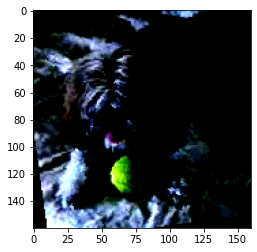

In [19]:
#посмотрим полученные изображения с выводом класса
show_example(*train_full_ds[0])

Label:  Old English sheepdog (9)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


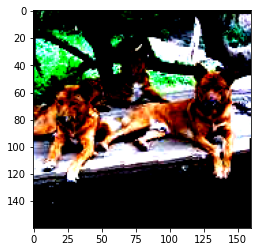

In [20]:
show_example(*train_full_ds[9000])

## Создание модели

In [21]:
random_seed = 43
torch.manual_seed(random_seed);
len(train_full_ds)

9025

In [22]:
#Выделим 500 изображений для валидации модели

val_size = 500
train_size = len(train_full_ds) - val_size
train_ds, val_ds = random_split(train_full_ds, [train_size, val_size])
len(train_ds), len(val_ds)

(8525, 500)

In [23]:
#Оптимальный размер батча исходя из имеющегося железа
batch_size = 32

In [24]:
#загрузка данных батчами

train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers= 4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size * 2, num_workers=4, pin_memory=True)

In [25]:
def denormalize(images, means, stds):
  means = torch.tensor(means).reshape(1,3,1,1)
  stds = torch.tensor(stds).reshape(1,3,1,1,)
  return images * stds + means

def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize = (12,12))
    ax.set_xticks([]), ax.set_yticks([])
    denorm_images = denormalize(images, *stats)
    ax.imshow(make_grid(denorm_images[:64],nrow = 8).permute(1,2,0).clamp(0,1))
    break

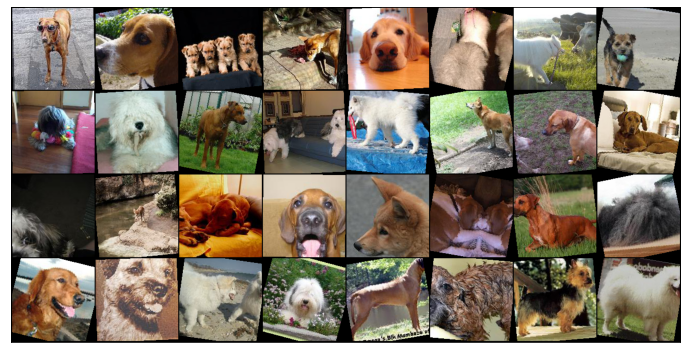

In [26]:
show_batch(train_dl)

In [27]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))
       
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [28]:
class Imagewoof(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(4, 4), # output: 64 x 40 x 40

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 1024 x 20 x 20
            nn.Conv2d(1024, 2048, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(2048, 2048, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(4, 4), # output: 1024 x 5 x 5

            nn.Flatten(), 
            nn.Linear(2048 * 5 * 5, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10))
     
    def forward(self, xb):
        return self.network(xb)

In [29]:
model = Imagewoof()
model

Imagewoof(
  (network): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(1024, 2048, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(2048, 2048, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=51200, out_features=2048, bias=True)
    (17): ReLU()
    (18): Linear(in_

In [30]:
for images, labels in train_dl:
  print('images.shape', images.shape)
  out = model(images)
  print('out.shape', out.shape)
  print('out[0]:', out[0])
  break

images.shape torch.Size([32, 3, 160, 160])
out.shape torch.Size([32, 10])
out[0]: tensor([-3.0474e-02, -7.0222e-02, -1.4836e-02, -6.4510e-02,  3.2506e-05,
        -1.9755e-03, -2.7444e-02, -2.8916e-02,  5.1939e-02, -4.0166e-02],
       grad_fn=<SelectBackward>)


In [31]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
   
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [32]:
#Проверка GPU

device = get_default_device()
device

device(type='cuda')

In [33]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

## Тренировка модели

In [34]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [35]:
model = to_device(Imagewoof(), device)

In [36]:
evaluate(model, val_dl)

{'val_acc': 0.11147836595773697, 'val_loss': 2.303361415863037}

In [37]:
# Проверка RAdam
# !pip install git+https://github.com/LiyuanLucasLiu/RAdam
# from radam import RAdam
# num_epochs = 20
# opt_func = RAdam
# lr = 0.0001

In [38]:
num_epochs = 15
opt_func = torch.optim.Adam

lr = 0.0001

In [39]:
%%time
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [1], train_loss: 2.1592, val_loss: 2.0987, val_acc: 0.2103
Epoch [2], train_loss: 2.0190, val_loss: 1.9714, val_acc: 0.2652
Epoch [3], train_loss: 1.9112, val_loss: 1.9009, val_acc: 0.3002
Epoch [4], train_loss: 1.8075, val_loss: 1.8320, val_acc: 0.3328
Epoch [5], train_loss: 1.7135, val_loss: 1.8582, val_acc: 0.3377
Epoch [6], train_loss: 1.6052, val_loss: 1.6672, val_acc: 0.4235
Epoch [7], train_loss: 1.4896, val_loss: 1.4872, val_acc: 0.4611
Epoch [8], train_loss: 1.3831, val_loss: 1.4929, val_acc: 0.4504
Epoch [9], train_loss: 1.2744, val_loss: 1.4225, val_acc: 0.4991
Epoch [10], train_loss: 1.1579, val_loss: 1.2868, val_acc: 0.5397
Epoch [11], train_loss: 1.0585, val_loss: 1.2217, val_acc: 0.5766
Epoch [12], train_loss: 0.9677, val_loss: 1.1995, val_acc: 0.5965
Epoch [13], train_loss: 0.8885, val_loss: 1.2174, val_acc: 0.6064
Epoch [14], train_loss: 0.8190, val_loss: 1.1651, val_acc: 0.6025
Epoch [15], train_loss: 0.7327, val_loss: 1.1021, val_acc: 0.6370
CPU times: user 12m

In [40]:
# %%time
# history += fit(5, 0.00001, model, train_dl, val_dl, opt_func)

In [41]:
def plot_accuracies(history):
  accuracies = [x['val_acc'] for x in history]
  plt.plot(accuracies, '-x')
  plt.xlabel('epoch')
  plt.ylabel(['accuracy'])
  plt.title('Accuracy vs No. of epoch')


In [42]:
def plot_losses(history):
  train_losses = [x.get('train_loss') for x in history]
  val_losses = [x['val_loss'] for x in history]
  plt.plot(train_losses, '-bx')
  plt.plot(val_losses, '-rx')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Training','Validation'])
  plt.title('Loss vs No. of epoch')

## Точность модели

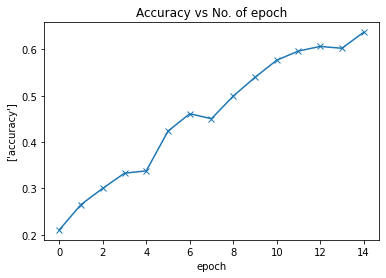

In [43]:
plot_accuracies(history)

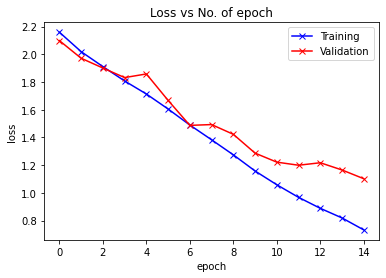

In [44]:
plot_losses(history)

In [45]:
def predict_image(img, model):
  # Convert to a batch of 1
  xb = to_device(img.unsqueeze(0),device)
  yb = model(xb)
  # Pick index with highest probability
  _, preds = torch.max(yb, dim = 1)
  # Retrieve the class label
  return classes[preds[0].item()]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: Golden retriever , Predicted: Beagle


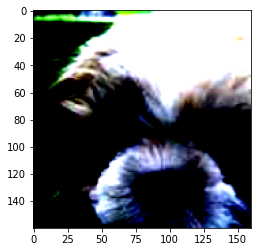

In [46]:
img, label = test_ds[0]
plt.imshow(img.permute(1,2,0))
print("Label:", classes[label], ', Predicted:', predict_image(img,model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: Golden retriever , Predicted: Shih-Tzu


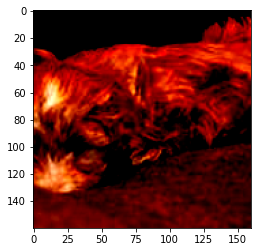

In [47]:
img, label = test_ds[250]
plt.imshow(img.permute(1,2,0))
print("Label:", classes[label], ', Predicted:', predict_image(img,model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: Golden retriever , Predicted: Golden retriever


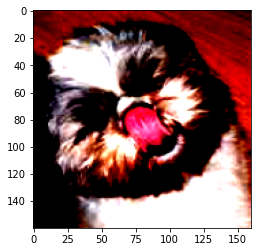

In [48]:
img, label = test_ds[400]
plt.imshow(img.permute(1,2,0))
print("Label:", classes[label], ', Predicted:', predict_image(img,model))

## Сохранение модели

In [49]:
test_loader = DeviceDataLoader(DataLoader(test_ds, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.48005038499832153, 'val_loss': 1.6433416604995728}

In [50]:
torch.save(model.state_dict(), 'imagewoof-1.pth')

In [51]:
model2 = to_device(Imagewoof(), device)

In [52]:
model2.load_state_dict(torch.load('imagewoof-1.pth'))

<All keys matched successfully>

In [53]:
evaluate(model2, test_loader)

{'val_acc': 0.47968751192092896, 'val_loss': 1.6397724151611328}